In [1]:
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip
from torch.utils.data import DataLoader, Subset, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import copy
from tqdm import tqdm
from torchvision.ops import box_iou, nms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from torchmetrics.detection.mean_ap import MeanAveragePrecision


# Set random seeds
torch.manual_seed(42)
random.seed(42)

# Device-agnostic setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print(f"Using device: {device}")

c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
device

device(type='cuda')

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Loading and Preprocessing the data

In [3]:
# Category mapping
category_names = {'pedestrian': 1, 'rider': 2, 'car': 3, 'truck': 4, 'bus': 5,
                  'train': 6, 'motorcycle': 7, 'bicycle': 8, 'traffic light': 9, 'traffic sign': 10}
id_to_category = {v: k for k, v in category_names.items()}

# Helper function to validate bounding boxes
def is_valid_box(box):
    x1, y1, x2, y2 = box
    return x2 > x1 and y2 > y1

# Simple Dataset
class BDD100KDataset(Dataset):
    def __init__(self, img_root, label_root):
        self.img_root = img_root
        self.label_root = label_root
        self.imgs = sorted([f for f in os.listdir(img_root) if f.endswith('.jpg')])
        self.labels = sorted([f for f in os.listdir(label_root) if f.endswith('.json')])
        self.transform = Compose([
            Resize((300, 300)),
            RandomHorizontalFlip(p=0.5),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        print(f"Loaded {len(self.imgs)} image-label pairs")

    def __getitem__(self, index):
        img_path = os.path.join(self.img_root, self.imgs[index])
        label_path = os.path.join(self.label_root, self.labels[index])
        try:
            img = Image.open(img_path).convert('RGB')
            # img = self.transform(img)
            img = ToTensor()(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img = torch.zeros((3, 720, 1280))  # Fallback size
        try:
            with open(label_path, 'r') as f:
                ann = json.load(f)
        except Exception as e:
            print(f"Error loading {label_path}: {e}")
            ann = {'frames': [{'objects': []}]}
        boxes = []
        labels = []
        for obj in ann.get('frames', [{}])[0].get('objects', []):
            category = obj.get('category')
            if category in category_names:
                box2d = obj.get('box2d', {})
                if all(k in box2d for k in ['x1', 'y1', 'x2', 'y2']):
                    box = [box2d['x1'], box2d['y1'], box2d['x2'], box2d['y2']]
                    if is_valid_box(box):
                        boxes.append(box)
                        labels.append(category_names[category])
                    else:
                        print(f"Warning: Invalid box {box} in {self.imgs[index]} skipped")
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        if len(boxes) == 0:
            print(f"Warning: Image {self.imgs[index]} has no valid annotations")
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index])}
        return img, target

    def __len__(self):
        return len(self.imgs)


# Creating Faster R-CNN from scratch

In [4]:
class CustomBoxPredictor(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.shared_fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 1024),
            nn.ReLU()
        )
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

    def forward(self, x):
        x = self.shared_fc(x)
        scores = self.cls_score(x)  # [N, num_classes]
        bbox_deltas = self.bbox_pred(x)  # [N, num_classes * 4]
        bbox_deltas = bbox_deltas.view(-1, scores.shape[1], 4)  # [N, num_classes, 4]
        return scores, bbox_deltas


class CustomFasterRCNN(FasterRCNN):
    def __init__(self, num_classes):
        # Build FPN backbone from resnet50 (no pretrained weights)
        backbone = resnet_fpn_backbone('resnet50', pretrained=False)

        # Define anchor generator for each feature map
        anchor_generator = AnchorGenerator(
            sizes=((32,), (64,), (128,), (256,), (512,)),
            aspect_ratios=((0.5, 1.0, 2.0),) * 5
        )
        # Define ROI aligner
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2)
        # Initialize the parent FasterRCNN with custom config
        super().__init__(backbone,
                         num_classes=num_classes,
                         rpn_anchor_generator=anchor_generator,
                         box_roi_pool=roi_pooler)
        in_features = self.roi_heads.box_predictor.cls_score.in_features
        self.roi_heads.box_predictor = CustomBoxPredictor(in_features, num_classes)

    def forward(self, images, targets=None):
        return super().forward(images, targets)


# Create Dataset and Dataloaders

In [5]:
# Load datasets
img_root = r'C:\Users\nandi\OneDrive\Desktop\SUNY BUFFALO SUM SEM DL\Final Project\bdd100k\images'  # Update this
label_root = r'C:\Users\nandi\OneDrive\Desktop\SUNY BUFFALO SUM SEM DL\Final Project\bdd100k\labels'  # Update this
train_dataset = BDD100KDataset(os.path.join(img_root, 'train'), os.path.join(label_root, 'train'))
val_dataset = BDD100KDataset(os.path.join(img_root, 'val'), os.path.join(label_root, 'val'))


# Create subsets
train_subset = Subset(train_dataset, random.sample(range(len(train_dataset)), min(50, len(train_dataset))))
val_subset = Subset(val_dataset, random.sample(range(len(val_dataset)), min(10, len(val_dataset))))

# DataLoaders
dataloaders = {
    'train': DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x))),
    'val': DataLoader(val_subset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
}
print(f'Train subset size: {len(train_subset)}')
print(f'Validation subset size: {len(val_subset)}')

Loaded 70000 image-label pairs
Loaded 10000 image-label pairs
Train subset size: 50
Validation subset size: 10


# Dataset statistics

In [ ]:
def get_dataset_stats(dataset):
    category_counts = {}
    box_counts = []
    for i in range(len(dataset)):
        try:
            _, target = dataset[i]
            labels = target['labels'].numpy()
            for label in labels:
                category_counts[label] = category_counts.get(label, 0) + 1
            box_counts.append(len(labels))
        except Exception as e:
            print(f"Error processing index {i}: {e}")
    return {'num_images': len(dataset), 'category_counts': category_counts, 'avg_boxes_per_image': np.mean(box_counts) if box_counts else 0}

train_stats = get_dataset_stats(train_subset)
val_stats = get_dataset_stats(val_subset)

print('Train Stats:')
print(f'Images: {train_stats["num_images"]}, Avg boxes/image: {train_stats["avg_boxes_per_image"]:.2f}')
for cat_id, count in train_stats['category_counts'].items():
    print(f'  {id_to_category.get(cat_id, cat_id)}: {count}')

print('\nVal Stats:')
print(f'Images: {val_stats["num_images"]}, Avg boxes/image: {val_stats["avg_boxes_per_image"]:.2f}')
for cat_id, count in val_stats['category_counts'].items():
    print(f'  {id_to_category.get(cat_id, cat_id)}: {count}')

Train Stats:
Images: 50, Avg boxes/image: 14.78
  car: 454
  traffic sign: 159
  bus: 14
  traffic light: 87
  truck: 23
  rider: 2

Val Stats:
Images: 10, Avg boxes/image: 14.50
  car: 92
  traffic sign: 29
  truck: 6
  traffic light: 17
  bus: 1


# Visualizations

Visualizing 3 images...


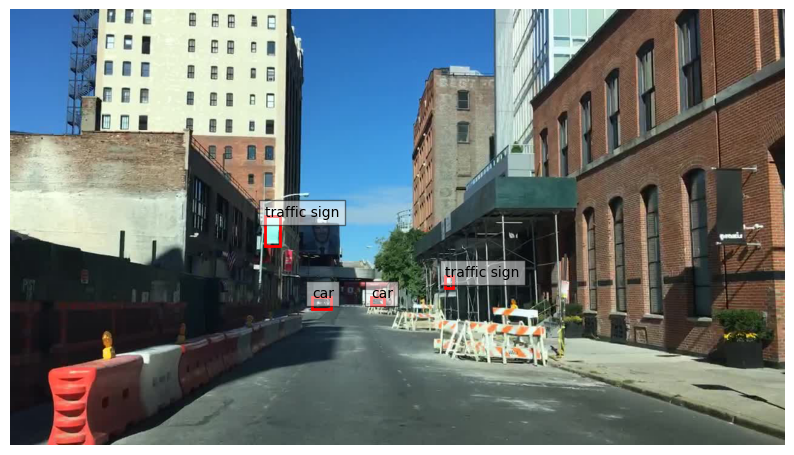

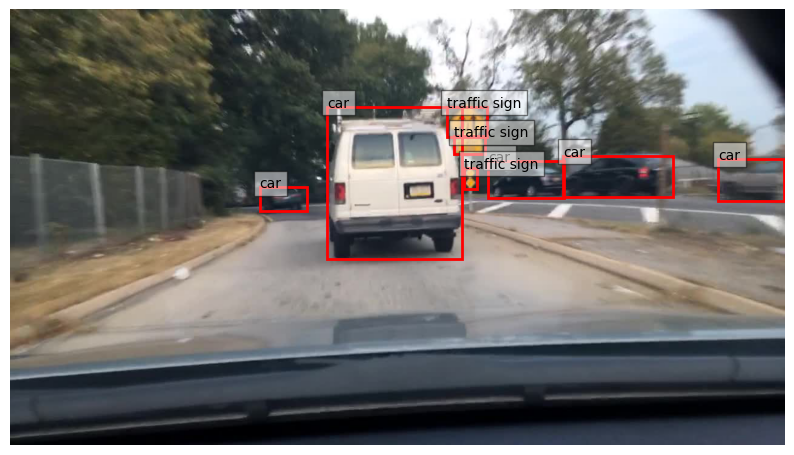

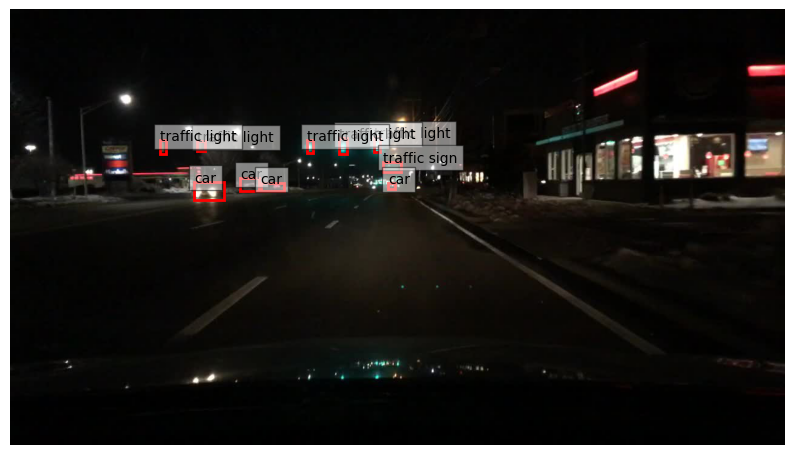

In [ ]:
def visualize_image(dataset, idx):
    try:
        img, target = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        boxes = target['boxes'].numpy()
        labels = target['labels'].numpy()
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        ax = plt.gca()
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1, id_to_category.get(label, label), bbox=dict(facecolor='white', alpha=0.5))
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Vis error {idx}: {e}")

print("Visualizing 3 images...")
for i in random.sample(range(len(train_subset)), min(3, len(train_subset))):
    visualize_image(train_subset, i)

# Initializing model

In [9]:
num_classes = 11  # 10 classes + background
model = fasterrcnn_resnet50_fpn(weights=None, num_classes=num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
print('Model initialized on device')


Model initialized on device


# Training the model

In [6]:
import torch
import time
import copy
import torchvision
from tqdm import tqdm

def train_model(model, dataloaders, optimizer, num_epochs=10, device='cuda'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                if phase not in dataloaders:
                    continue
                model.train()  # Keep in train mode for loss computation during validation

            running_loss = 0.0

            for images, targets in tqdm(dataloaders[phase]):
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    loss_dict = model(images, targets)  # Always pass targets to get loss
                    losses = sum(loss for loss in loss_dict.values())
                    running_loss += losses.item()

                    if phase == 'train':
                        losses.backward()
                        optimizer.step()

            epoch_loss = running_loss / len(dataloaders[phase])
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}")

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_fasterrcnn_model.pth')

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    model.load_state_dict(best_model_wts)
    return model


# Trained using Custom Faster R CNN

In [7]:
num_classes = 11
model = CustomFasterRCNN(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
print('Model initialized on device')

c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model initialized on device


In [10]:
model = train_model(model, dataloaders, optimizer, num_epochs=3, device=device)


Epoch 1/3
------------------------------


100%|██████████| 13/13 [08:18<00:00, 38.34s/it]


Train Loss: 2.1223


100%|██████████| 3/3 [00:38<00:00, 12.95s/it]


Val Loss: 1.3397

Epoch 2/3
------------------------------


100%|██████████| 13/13 [08:28<00:00, 39.13s/it]


Train Loss: 1.1389


100%|██████████| 3/3 [00:42<00:00, 14.10s/it]


Val Loss: 1.3447

Epoch 3/3
------------------------------


100%|██████████| 13/13 [09:30<00:00, 43.85s/it]


Train Loss: 1.1257


100%|██████████| 3/3 [00:42<00:00, 14.08s/it]


Val Loss: 1.1560

Training complete in 28m 22s
Best val loss: 1.1560


# Trained using built-in Faster RCNN model

In [20]:
model = train_model(model, dataloaders, optimizer, num_epochs=5, device=device)


Epoch 1/5
------------------------------


100%|██████████| 13/13 [05:25<00:00, 25.01s/it]


Train Loss: 1.8048


100%|██████████| 3/3 [00:11<00:00,  3.99s/it]


Val Loss: 1.2429

Epoch 2/5
------------------------------


100%|██████████| 13/13 [05:37<00:00, 25.92s/it]


Train Loss: 1.2161


100%|██████████| 3/3 [00:16<00:00,  5.38s/it]


Val Loss: 1.0749

Epoch 3/5
------------------------------


100%|██████████| 13/13 [05:38<00:00, 26.04s/it]


Train Loss: 0.9613


100%|██████████| 3/3 [00:19<00:00,  6.38s/it]


Val Loss: 1.0244

Epoch 4/5
------------------------------


100%|██████████| 13/13 [05:27<00:00, 25.18s/it]


Train Loss: 0.9617


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


Val Loss: 1.3675

Epoch 5/5
------------------------------


100%|██████████| 13/13 [05:19<00:00, 24.56s/it]


Train Loss: 1.0946


100%|██████████| 3/3 [00:16<00:00,  5.41s/it]

Val Loss: 1.5136

Training complete in 28m 48s
Best val loss: 1.0244


# Experimenting with Larger subset and more epochs

In [7]:
train_sub = Subset(train_dataset, random.sample(range(len(train_dataset)), min(500, len(train_dataset))))
val_sub = Subset(val_dataset, random.sample(range(len(val_dataset)), min(100, len(val_dataset))))

# DataLoaders
dataloaders = {
    'train': DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x))),
    'val': DataLoader(val_subset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
}

In [8]:
model = train_model(model, dataloaders, optimizer, num_epochs=15, device=device)


Epoch 1/15
------------------------------


100%|██████████| 13/13 [04:08<00:00, 19.10s/it]


Train Loss: 1.8815


100%|██████████| 3/3 [00:13<00:00,  4.36s/it]


Val Loss: 1.3208

Epoch 2/15
------------------------------


100%|██████████| 13/13 [04:43<00:00, 21.82s/it]


Train Loss: 1.2371


100%|██████████| 3/3 [00:12<00:00,  4.33s/it]


Val Loss: 1.2477

Epoch 3/15
------------------------------


100%|██████████| 13/13 [04:29<00:00, 20.75s/it]


Train Loss: 1.0073


100%|██████████| 3/3 [00:13<00:00,  4.44s/it]


Val Loss: 1.2846

Epoch 4/15
------------------------------


100%|██████████| 13/13 [04:30<00:00, 20.77s/it]


Train Loss: 1.0331


100%|██████████| 3/3 [00:11<00:00,  3.92s/it]


Val Loss: 1.0764

Epoch 5/15
------------------------------


100%|██████████| 13/13 [04:25<00:00, 20.43s/it]


Train Loss: 0.9727


100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


Val Loss: 1.2866

Epoch 6/15
------------------------------


100%|██████████| 13/13 [04:09<00:00, 19.19s/it]


Train Loss: 1.0054


100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


Val Loss: 1.2480

Epoch 7/15
------------------------------


100%|██████████| 13/13 [04:03<00:00, 18.72s/it]


Train Loss: 0.9683


100%|██████████| 3/3 [00:11<00:00,  3.70s/it]


Val Loss: 1.2805

Epoch 8/15
------------------------------


100%|██████████| 13/13 [03:56<00:00, 18.22s/it]


Train Loss: 1.0230


100%|██████████| 3/3 [00:11<00:00,  3.67s/it]


Val Loss: 1.5263

Epoch 9/15
------------------------------


100%|██████████| 13/13 [04:01<00:00, 18.58s/it]


Train Loss: 1.1117


100%|██████████| 3/3 [00:10<00:00,  3.54s/it]


Val Loss: 1.3962

Epoch 10/15
------------------------------


100%|██████████| 13/13 [03:55<00:00, 18.08s/it]


Train Loss: 1.1257


100%|██████████| 3/3 [00:10<00:00,  3.55s/it]


Val Loss: 1.4638

Epoch 11/15
------------------------------


100%|██████████| 13/13 [03:43<00:00, 17.22s/it]


Train Loss: 1.1511


100%|██████████| 3/3 [00:10<00:00,  3.58s/it]


Val Loss: 1.8088

Epoch 12/15
------------------------------


100%|██████████| 13/13 [03:30<00:00, 16.20s/it]


Train Loss: 1.2242


100%|██████████| 3/3 [00:09<00:00,  3.06s/it]


Val Loss: 1.4794

Epoch 13/15
------------------------------


100%|██████████| 13/13 [02:58<00:00, 13.69s/it]


Train Loss: 1.2580


100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


Val Loss: 1.7327

Epoch 14/15
------------------------------


100%|██████████| 13/13 [03:34<00:00, 16.46s/it]


Train Loss: 1.2538


100%|██████████| 3/3 [00:11<00:00,  3.83s/it]


Val Loss: 1.7421

Epoch 15/15
------------------------------


100%|██████████| 13/13 [03:56<00:00, 18.22s/it]


Train Loss: 1.2705


100%|██████████| 3/3 [00:12<00:00,  4.22s/it]

Val Loss: 1.6428

Training complete in 62m 59s
Best val loss: 1.0764


# Evaluation

In [8]:
from torchvision.ops import box_iou

def evaluate_fasterrcnn(model, dataloader, device='cuda', iou_threshold=0.5, score_threshold=0.5):
    model.to(device)
    model.eval()

    total_TP, total_FP, total_FN = 0, 0, 0
    total_loss = 0.0
    num_batches = 0

    for images, targets in tqdm(dataloader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Compute Loss
        model.train()
        with torch.set_grad_enabled(False):
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            total_loss += loss.item()
            num_batches += 1

        # Inference
        model.eval()
        with torch.no_grad():
            outputs = model(images)

        # Compute Precision/Recall
        for pred, target in zip(outputs, targets):
            # print(f"Pred scores: {pred['scores'].tolist()}")
            # print(f"Pred boxes: {pred['boxes'].shape}")
            # print(f"Ground truth boxes: {target['boxes'].shape}")
            keep = pred['scores'] > score_threshold
            pred_boxes = pred['boxes'][keep]
            pred_labels = pred['labels'][keep]

            gt_boxes = target['boxes']
            gt_labels = target['labels']

            if len(pred_boxes) == 0:
                total_FN += len(gt_boxes)
                continue
            if len(gt_boxes) == 0:
                total_FP += len(pred_boxes)
                continue

            ious = box_iou(pred_boxes, gt_boxes)
            matched_gt = set()
            TP = 0

            for pred_idx in range(len(pred_boxes)):
                iou_values = ious[pred_idx]
                max_iou, gt_idx = torch.max(iou_values, dim=0)
                if max_iou.item() >= iou_threshold and gt_idx.item() not in matched_gt:
                    if pred_labels[pred_idx] == gt_labels[gt_idx]:
                        TP += 1
                        matched_gt.add(gt_idx.item())

            FP = len(pred_boxes) - TP
            FN = len(gt_boxes) - TP

            total_TP += TP
            total_FP += FP
            total_FN += FN

    precision = total_TP / (total_TP + total_FP + 1e-6)
    recall = total_TP / (total_TP + total_FN + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    avg_loss = total_loss / (num_batches + 1e-6)

    print(f"\nEvaluation Metrics @IoU={iou_threshold}, score > {score_threshold}")
    print(f"Test Loss:  {avg_loss:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"F1 Score:   {f1_score:.4f}")

    return avg_loss, precision, recall, f1_score

In [28]:
test_dataset = BDD100KDataset(os.path.join(img_root, 'test'), os.path.join(label_root, 'test'))
test_subset = Subset(test_dataset, random.sample(range(len(test_dataset)), min(30, len(test_dataset))))

test_loader = DataLoader(test_subset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
evaluate_fasterrcnn(model, test_loader, device=device, iou_threshold=0.3, score_threshold=0.1)

Loaded 20000 image-label pairs


  7%|▋         | 1/15 [00:01<00:25,  1.81s/it]

Pred scores: [0.18633000552654266, 0.16653254628181458, 0.13994285464286804, 0.10773521661758423]
Pred boxes: torch.Size([4, 4])
Ground truth boxes: torch.Size([14, 4])
Pred scores: [0.19950264692306519, 0.175665944814682, 0.1532086580991745, 0.08840735256671906, 0.05901816487312317, 0.05684058368206024, 0.05157124251127243]
Pred boxes: torch.Size([7, 4])
Ground truth boxes: torch.Size([17, 4])


 13%|█▎        | 2/15 [00:03<00:22,  1.71s/it]

Pred scores: [0.16764390468597412]
Pred boxes: torch.Size([1, 4])
Ground truth boxes: torch.Size([22, 4])
Pred scores: [0.17681924998760223]
Pred boxes: torch.Size([1, 4])
Ground truth boxes: torch.Size([14, 4])


 20%|██        | 3/15 [00:05<00:20,  1.70s/it]

Pred scores: [0.1901770830154419, 0.1780579686164856, 0.15688039362430573, 0.13708823919296265, 0.09947866946458817, 0.09910246729850769, 0.08317142724990845, 0.06620366126298904]
Pred boxes: torch.Size([8, 4])
Ground truth boxes: torch.Size([19, 4])
Pred scores: [0.18977519869804382, 0.17253293097019196, 0.152766153216362, 0.13323478400707245, 0.1254272162914276, 0.11569714546203613, 0.11422046273946762, 0.1094040721654892, 0.07933753728866577, 0.06169688329100609]
Pred boxes: torch.Size([10, 4])
Ground truth boxes: torch.Size([14, 4])


 27%|██▋       | 4/15 [00:06<00:18,  1.69s/it]

Pred scores: [0.21340633928775787, 0.1772080808877945, 0.1752670556306839]
Pred boxes: torch.Size([3, 4])
Ground truth boxes: torch.Size([18, 4])
Pred scores: [0.2030980885028839, 0.20079655945301056, 0.19761385023593903, 0.16965115070343018, 0.1637251377105713, 0.12947086989879608, 0.12068440765142441, 0.11030066758394241, 0.10454846173524857, 0.09437683969736099, 0.08824239671230316, 0.08677754551172256, 0.08210430294275284, 0.08184567838907242, 0.0796954333782196, 0.07794619351625443, 0.077908456325531, 0.07416494190692902, 0.0725923627614975, 0.07083123922348022, 0.06794003397226334, 0.059969328343868256, 0.05230136960744858, 0.050857063382864, 0.050239916890859604]
Pred boxes: torch.Size([25, 4])
Ground truth boxes: torch.Size([7, 4])


 33%|███▎      | 5/15 [00:08<00:17,  1.72s/it]

Pred scores: [0.19014938175678253, 0.18304091691970825, 0.1505434364080429, 0.14814387261867523, 0.13149361312389374, 0.1128767654299736, 0.11130465567111969, 0.10754948109388351, 0.10050072520971298, 0.09839620441198349, 0.09792543202638626, 0.0727890133857727, 0.05277903378009796, 0.052100736647844315]
Pred boxes: torch.Size([14, 4])
Ground truth boxes: torch.Size([12, 4])
Pred scores: [0.2115873247385025, 0.2112998515367508, 0.19677065312862396, 0.18907430768013, 0.1732439398765564, 0.17256447672843933, 0.16295257210731506, 0.15590733289718628, 0.1528998613357544, 0.1347663551568985, 0.13317444920539856, 0.12798619270324707, 0.11756815761327744, 0.11260693520307541, 0.10470634698867798, 0.09641356766223907, 0.09441319853067398, 0.09360398352146149, 0.08842917531728745, 0.08829847723245621, 0.08747313171625137, 0.07912226021289825, 0.07840884476900101, 0.0721874013543129, 0.06972244381904602, 0.06591837853193283, 0.06434530019760132, 0.06431857496500015, 0.06425605714321136, 0.064215

 40%|████      | 6/15 [00:10<00:15,  1.75s/it]

Pred scores: [0.18534576892852783, 0.14008253812789917, 0.11703241616487503, 0.11641205102205276, 0.11373110860586166, 0.11288028955459595, 0.11245506256818771, 0.11100713908672333, 0.11028371006250381, 0.10907428711652756, 0.10804319381713867, 0.10752787441015244, 0.10714919865131378, 0.1069142296910286, 0.10494936257600784, 0.10378409177064896, 0.10258356481790543, 0.10201775282621384, 0.10120299458503723, 0.10020249336957932, 0.09936951100826263, 0.09881819784641266, 0.09825560450553894, 0.09776219725608826, 0.09774105250835419, 0.09710647910833359, 0.0969863310456276, 0.09553703665733337, 0.09513318538665771, 0.09510783106088638, 0.09501881152391434, 0.09373242408037186, 0.09335239231586456, 0.09331988543272018, 0.09310219436883926, 0.09220380336046219, 0.09212217479944229, 0.09189921617507935, 0.09036799520254135, 0.08853313326835632, 0.08840357512235641, 0.08698953688144684, 0.0859786719083786, 0.08514750748872757, 0.08447742462158203, 0.08291379362344742, 0.08039213716983795, 0.

 47%|████▋     | 7/15 [00:12<00:13,  1.73s/it]

Pred scores: [0.19783036410808563, 0.18026109039783478, 0.1729232519865036, 0.1497541069984436, 0.1416105329990387, 0.10111038386821747, 0.0945424884557724, 0.09138166904449463, 0.08637482672929764, 0.07843773066997528, 0.07315125316381454, 0.06537778675556183, 0.05903421714901924, 0.05048760026693344]
Pred boxes: torch.Size([14, 4])
Ground truth boxes: torch.Size([8, 4])
Pred scores: [0.20456792414188385, 0.19708400964736938, 0.17561380565166473, 0.12600590288639069, 0.11852677911520004, 0.11813760548830032, 0.11563485115766525, 0.09677856415510178, 0.08625233918428421, 0.08558742702007294, 0.08508577942848206, 0.08305247873067856, 0.07079358398914337, 0.06960757821798325, 0.06851480156183243, 0.06462030112743378, 0.05705117806792259, 0.0555795282125473]
Pred boxes: torch.Size([18, 4])
Ground truth boxes: torch.Size([13, 4])


 53%|█████▎    | 8/15 [00:13<00:12,  1.73s/it]

Pred scores: [0.1608375757932663, 0.06182282790541649, 0.053803808987140656]
Pred boxes: torch.Size([3, 4])
Ground truth boxes: torch.Size([25, 4])
Pred scores: [0.13612811267375946, 0.13110820949077606, 0.12082813680171967, 0.11917757242918015, 0.11739685386419296, 0.11410253494977951, 0.10976797342300415, 0.10803307592868805, 0.10601946711540222, 0.09230661392211914, 0.07346592843532562, 0.055813733488321304, 0.051999691873788834]
Pred boxes: torch.Size([13, 4])
Ground truth boxes: torch.Size([15, 4])


 60%|██████    | 9/15 [00:15<00:10,  1.71s/it]

Pred scores: [0.18179360032081604, 0.1714494377374649, 0.1653313934803009, 0.15093743801116943, 0.11786437779664993, 0.11364918202161789, 0.10859569907188416, 0.1026482880115509, 0.09929719567298889, 0.09901818633079529, 0.08860217779874802, 0.08835221827030182, 0.08713962882757187, 0.08638034760951996, 0.08390824496746063, 0.079328753054142, 0.07860217243432999, 0.07419665902853012, 0.0640927106142044, 0.06329528987407684, 0.0589074045419693, 0.055052902549505234, 0.05445374175906181, 0.053765811026096344, 0.05144133046269417]
Pred boxes: torch.Size([25, 4])
Ground truth boxes: torch.Size([23, 4])
Pred scores: [0.1760488599538803, 0.16823765635490417, 0.1386651247739792, 0.10250738263130188, 0.08585741370916367, 0.060391515493392944, 0.05123570188879967]
Pred boxes: torch.Size([7, 4])
Ground truth boxes: torch.Size([32, 4])


 67%|██████▋   | 10/15 [00:17<00:08,  1.69s/it]

Pred scores: [0.1968746781349182, 0.1642959713935852, 0.10167118906974792, 0.09678266942501068, 0.09369214624166489, 0.0928746685385704, 0.088849276304245, 0.08638802170753479, 0.08595488220453262, 0.08574250340461731, 0.07579366862773895, 0.07279357314109802, 0.06956826895475388, 0.06753646582365036, 0.06620080024003983, 0.06461700052022934, 0.06374198943376541, 0.06298615783452988, 0.062102559953927994, 0.06176983192563057, 0.059603262692689896, 0.05935269221663475, 0.05741884559392929, 0.05608060583472252, 0.05601092055439949, 0.056000806391239166, 0.05472365766763687, 0.053999029099941254, 0.05338427796959877, 0.05314784497022629, 0.052669648081064224, 0.05264752730727196, 0.05227430537343025, 0.05219278857111931, 0.05210812762379646, 0.05076556280255318, 0.05066792666912079, 0.05023011192679405]
Pred boxes: torch.Size([38, 4])
Ground truth boxes: torch.Size([17, 4])
Pred scores: [0.18942192196846008, 0.17277534306049347, 0.1508302092552185, 0.1440686732530594, 0.14147348701953888,

 73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]

Pred scores: [0.1760890781879425, 0.13150101900100708, 0.10949425399303436]
Pred boxes: torch.Size([3, 4])
Ground truth boxes: torch.Size([21, 4])
Pred scores: [0.09131459146738052, 0.06272692233324051]
Pred boxes: torch.Size([2, 4])
Ground truth boxes: torch.Size([6, 4])


 80%|████████  | 12/15 [00:20<00:05,  1.68s/it]

Pred scores: [0.057864442467689514, 0.05220220237970352]
Pred boxes: torch.Size([2, 4])
Ground truth boxes: torch.Size([25, 4])
Pred scores: [0.1800798773765564, 0.15150034427642822, 0.10298386216163635, 0.10286425054073334, 0.05554238334298134]
Pred boxes: torch.Size([5, 4])
Ground truth boxes: torch.Size([41, 4])


 87%|████████▋ | 13/15 [00:22<00:03,  1.67s/it]

Pred scores: [0.18549469113349915, 0.18345127999782562, 0.1640387922525406]
Pred boxes: torch.Size([3, 4])
Ground truth boxes: torch.Size([16, 4])
Pred scores: [0.1658211350440979, 0.11566627025604248, 0.11234061419963837]
Pred boxes: torch.Size([3, 4])
Ground truth boxes: torch.Size([26, 4])


 93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Pred scores: [0.19428034126758575, 0.1572854071855545, 0.12580513954162598, 0.10335660725831985, 0.09617168456315994, 0.09091027081012726, 0.08579297363758087, 0.07600054889917374, 0.0715472400188446, 0.07141489535570145, 0.06904707103967667, 0.06385837495326996, 0.06106962636113167, 0.05769196152687073, 0.050404638051986694, 0.05001567304134369]
Pred boxes: torch.Size([16, 4])
Ground truth boxes: torch.Size([7, 4])
Pred scores: [0.20273207128047943, 0.18103018403053284, 0.17726266384124756, 0.16962726414203644, 0.16527827084064484, 0.15042626857757568, 0.13752923905849457, 0.13013294339179993, 0.11963290721178055, 0.10713160783052444, 0.100901760160923, 0.0984201729297638, 0.07810032367706299, 0.0740625411272049, 0.07108407467603683, 0.0702059417963028, 0.06405419856309891, 0.05368603393435478]
Pred boxes: torch.Size([18, 4])
Ground truth boxes: torch.Size([35, 4])


100%|██████████| 15/15 [00:25<00:00,  1.69s/it]

Pred scores: [0.19945666193962097, 0.19922226667404175, 0.1876388043165207, 0.1087036281824112, 0.09468507766723633, 0.08616016060113907, 0.0713079497218132, 0.07096686214208603, 0.06380129605531693, 0.05843252316117287, 0.05798744782805443, 0.0516703799366951]
Pred boxes: torch.Size([12, 4])
Ground truth boxes: torch.Size([25, 4])
Pred scores: [0.18937543034553528, 0.17343375086784363, 0.14298459887504578, 0.12608486413955688, 0.11688335984945297, 0.11017781496047974, 0.09821517765522003, 0.08725282549858093, 0.08433043956756592, 0.06968659907579422, 0.06935315579175949, 0.06643538177013397, 0.058521926403045654, 0.056569188833236694, 0.05408452823758125, 0.052238110452890396, 0.05209202691912651, 0.05031716451048851, 0.05027523636817932]
Pred boxes: torch.Size([19, 4])
Ground truth boxes: torch.Size([8, 4])

Evaluation Metrics @IoU=0.3, score > 0.1
Test Loss:  0.8968
Precision:  0.1227
Recall:     0.0398
F1 Score:   0.0601


(0.8967981495627712,
 0.12269938575031052,
 0.03976143133248224,
 0.06005969019246496)

# Training the model on entire dataset with LR Scheduler

### Optimized training method

In [12]:
num_classes = 11  # 10 classes + background
model_full = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
model_full.to(device)
params = [p for p in model_full.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
print('Model initialized on device')

c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model initialized on device


In [9]:
def train_model_new(model, dataloaders, optimizer, scheduler, num_epochs=10, device='cuda'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                if phase not in dataloaders:
                    continue
                model.train()

            running_loss = 0.0

            for images, targets in tqdm(dataloaders[phase]):
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    running_loss += losses.item()

                    if phase == 'train':
                        losses.backward()
                        optimizer.step()

            epoch_loss = running_loss / len(dataloaders[phase])
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}")

            if phase == 'val':
                print(f"Validation loss_dict: {loss_dict}")
                scheduler.step(epoch_loss)

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_fasterrcnn_model.pth')

        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    model.load_state_dict(best_model_wts)
    return model

In [10]:
dataloaders_full = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x))),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
}

In [11]:
model = train_model(model_full, dataloaders_full, optimizer, num_epochs=5, device=device)

NameError: name 'model_full' is not defined

### The model was taking an unusually longer amount of time, so I decided to stop the training and focus on a smaller subset

# Training on a slightly smaller dataset

In [13]:
train_sub = Subset(train_dataset, random.sample(range(len(train_dataset)), min(50, len(train_dataset))))
val_sub = Subset(val_dataset, random.sample(range(len(val_dataset)), min(10, len(val_dataset))))

In [14]:
dataloaders_sub = {
    'train': DataLoader(train_sub, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x))),
    'val': DataLoader(val_sub, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
}

In [15]:
num_classes = 11  # 10 classes + background
model_sub = fasterrcnn_resnet50_fpn(weights=None, num_classes=num_classes)
model_sub.to(device)
params = [p for p in model_sub.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
print('Model initialized on device')

Model initialized on device


In [16]:
model = train_model_new(model_sub, dataloaders_sub, optimizer, scheduler, num_epochs=5, device=device)


Epoch 1/5
------------------------------


100%|██████████| 13/13 [03:25<00:00, 15.81s/it]


Train Loss: 1.9616


100%|██████████| 3/3 [00:09<00:00,  3.12s/it]


Val Loss: 1.2069
Validation loss_dict: {'loss_classifier': tensor(0.2467, device='cuda:0'), 'loss_box_reg': tensor(0.0096, device='cuda:0'), 'loss_objectness': tensor(0.6209, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.2581, device='cuda:0')}
Learning rate: 0.005000

Epoch 2/5
------------------------------


100%|██████████| 13/13 [03:17<00:00, 15.23s/it]


Train Loss: 1.2489


100%|██████████| 3/3 [00:09<00:00,  3.27s/it]


Val Loss: 1.0095
Validation loss_dict: {'loss_classifier': tensor(0.2818, device='cuda:0'), 'loss_box_reg': tensor(0.0536, device='cuda:0'), 'loss_objectness': tensor(0.3939, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.2424, device='cuda:0')}
Learning rate: 0.005000

Epoch 3/5
------------------------------


100%|██████████| 13/13 [03:47<00:00, 17.52s/it]


Train Loss: 1.2302


100%|██████████| 3/3 [00:10<00:00,  3.49s/it]


Val Loss: 1.1220
Validation loss_dict: {'loss_classifier': tensor(0.2383, device='cuda:0'), 'loss_box_reg': tensor(0.0112, device='cuda:0'), 'loss_objectness': tensor(0.6059, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.2772, device='cuda:0')}
Learning rate: 0.005000

Epoch 4/5
------------------------------


100%|██████████| 13/13 [03:39<00:00, 16.90s/it]


Train Loss: 1.2656


100%|██████████| 3/3 [00:10<00:00,  3.54s/it]


Val Loss: 1.0958
Validation loss_dict: {'loss_classifier': tensor(0.2542, device='cuda:0'), 'loss_box_reg': tensor(0.0403, device='cuda:0'), 'loss_objectness': tensor(0.4546, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.2693, device='cuda:0')}
Learning rate: 0.005000

Epoch 5/5
------------------------------


100%|██████████| 13/13 [03:41<00:00, 17.03s/it]


Train Loss: 1.2312


100%|██████████| 3/3 [00:10<00:00,  3.46s/it]

Val Loss: 1.1105
Validation loss_dict: {'loss_classifier': tensor(0.2457, device='cuda:0'), 'loss_box_reg': tensor(0.0478, device='cuda:0'), 'loss_objectness': tensor(0.5426, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.2479, device='cuda:0')}
Learning rate: 0.005000

Training complete in 18m 44s
Best val loss: 1.0095


# Visualize predictions

In [20]:
model.load_state_dict(torch.load(r'C:\Users\nandi\OneDrive\Desktop\SUNY BUFFALO SUM SEM DL\Final Project\results\faster_rcnn_nsoni.pth', map_location=device))


<All keys matched successfully>

In [15]:
def collate_fn(batch):
    valid_batch = [(img, tgt) for img, tgt in batch if img is not None and tgt is not None]
    if not valid_batch:
        return [], []
    images, targets = zip(*valid_batch)
    return list(images), list(targets)
def visualize_predictions(model, dataset, device='cuda', score_threshold=0.05):
    model.to(device)
    model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    count = 0
    for images, targets in dataloader:
        if count >= 3:
            break
        if not images or not targets:  # Check for empty batch
            print(f"Skipping empty batch at iteration {count}")
            continue

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            predictions = model(images)

        img = images[0].permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        pred_boxes = predictions[0]['boxes'].cpu().numpy()
        pred_labels = predictions[0]['labels'].cpu().numpy()
        pred_scores = predictions[0]['scores'].cpu().numpy()
        gt_boxes = targets[0]['boxes'].cpu().numpy()
        gt_labels = targets[0]['labels'].cpu().numpy()

        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        ax = plt.gca()

        # Plot predicted boxes (blue)
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            if score > score_threshold:
                x1, y1, x2, y2 = box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='blue', linewidth=2)
                ax.add_patch(rect)
                ax.text(x1, y1, f"{id_to_category.get(label, label)} ({score:.2f})",
                        bbox=dict(facecolor='blue', alpha=0.5))

        # Plot ground truth boxes (red)
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1, id_to_category.get(label, label),
                    bbox=dict(facecolor='red', alpha=0.5))

        plt.axis('off')
        plt.title(f"Image {count + 1}: Ground Truth (Red) vs Predictions (Blue)")
        plt.show()
        count += 1


Loaded 20000 image-label pairs


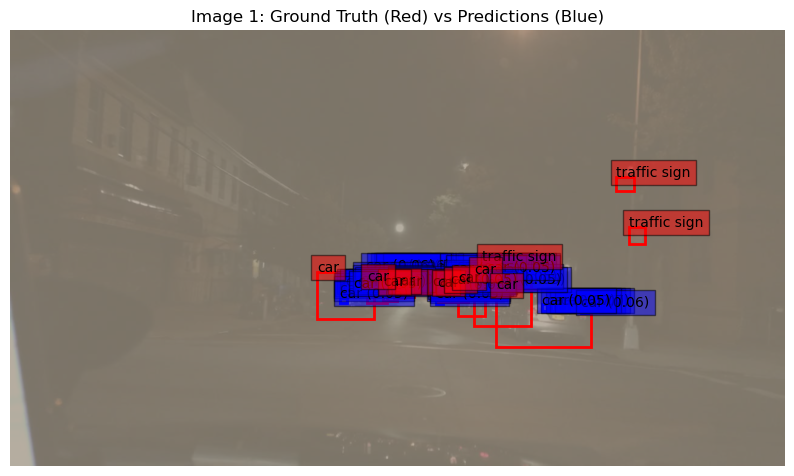

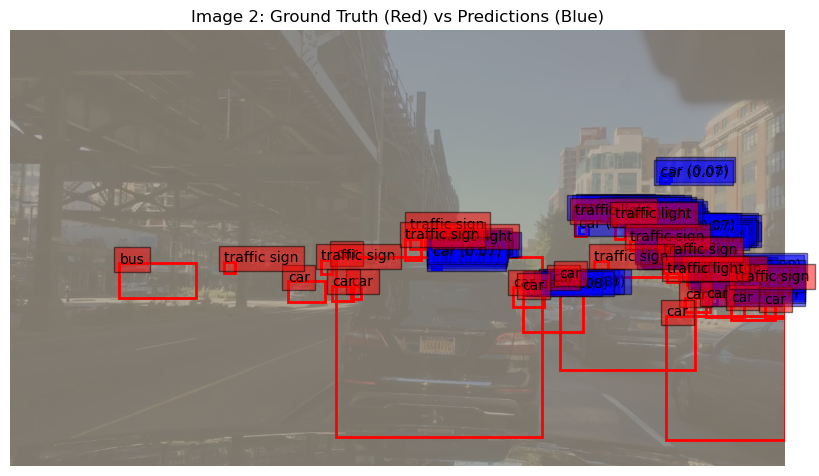

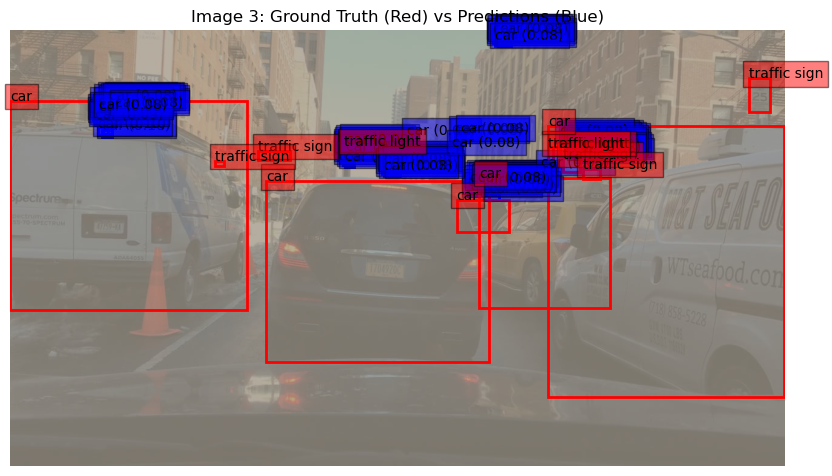

In [16]:
test_dataset = BDD100KDataset(os.path.join(img_root, 'test'), os.path.join(label_root, 'test'))
test_subset = Subset(test_dataset, random.sample(range(len(test_dataset)), min(30, len(test_dataset))))

test_loader = DataLoader(test_subset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
visualize_predictions(model, test_subset, device=device, score_threshold=0.05)